In [5]:
# Import libraries
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 400)
import requests
import matplotlib.pyplot as plt
import json
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [6]:
#random forest
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

In [7]:
from pickle import dump

In [8]:

salaries_df = pd.read_csv('Resources/salaries_cleaned.csv')

In [9]:
salaries_df.head()

,Unnamed: 0,timestamp,date,company,level,title,totalyearlycompensation,location,latitude,longitude,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,gender,Race,Education
0,0,2017-06-07 11:33:00,2017-06-07 00:00:00,Oracle,L3,Product Manager,127000,"Redwood City, CA",37.486324,-122.232523,1.5,1.5,107000,20000,10000,Unknown,Unknown,Unknown
1,1,2017-06-10 17:11:00,2017-06-10 00:00:00,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",37.779026,-122.419906,5.0,3.0,0,0,0,Unknown,Unknown,Unknown
2,2,2017-06-11 14:53:00,2017-06-11 00:00:00,Amazon,L7,Product Manager,310000,"Seattle, WA",47.603832,-122.330062,8.0,0.0,155000,0,0,Unknown,Unknown,Unknown
3,3,2017-06-17 00:23:00,2017-06-17 00:00:00,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",37.368830,-122.036349,7.0,5.0,157000,180000,35000,Unknown,Unknown,Unknown
4,4,2017-06-20 10:58:00,2017-06-20 00:00:00,Microsoft,60,Software Engineer,157000,"Mountain View, CA",37.389389,-122.083210,5.0,3.0,0,0,0,Unknown,Unknown,Unknown


In [10]:
salaries_df.columns

Index(['Unnamed: 0', 'timestamp', 'date', 'company', 'level', 'title',
       'totalyearlycompensation', 'location', 'latitude', 'longitude',
       'yearsofexperience', 'yearsatcompany', 'basesalary', 'stockgrantvalue',
       'bonus', 'gender', 'Race', 'Education'],
      dtype='object')

In [11]:
salaries_df['company'].value_counts()

Amazon             8208
Microsoft          5252
Google             4367
Facebook           3004
Apple              2055
                   ... 
CSV Health            1
Mckinsey              1
Tune                  1
Jp morgan chase       1
Csg                   1
Name: company, Length: 1076, dtype: int64

In [12]:
val=salaries_df['company'].value_counts()
print(val[val>25])

Amazon           8208
Microsoft        5252
Google           4367
Facebook         3004
Apple            2055
                 ... 
Glassdoor          26
Sony               26
HBO                26
ZS Associates      26
Huawei             26
Name: company, Length: 264, dtype: int64


In [13]:
#companies over 25 jobs
comapanies_to_replace=[]
company=salaries_df['company'].value_counts()
company=pd.DataFrame(company)
company.head(20)

,company
Amazon,8208
Microsoft,5252
Google,4367
Facebook,3004
Apple,2055
Oracle,1143
SalesForce,1065
Intel,991
Cisco,943
IBM,927


In [14]:
comapanies_to_replace.append(company[company.company<15].index)

In [15]:
#Replaced with other for all companies besides the top 20
for x in comapanies_to_replace:
    salaries_df['company'] = salaries_df['company'].replace(x,"Other")
    
# Check to make sure binning was successful
salaries_df['company'].value_counts()

Amazon                  8208
Microsoft               5252
Other                   4895
Google                  4367
Facebook                3004
                        ... 
Adyen                     15
WePay                     15
Kroger                    15
National Instruments      15
WarnerMedia               15
Name: company, Length: 398, dtype: int64

In [16]:
year_df=salaries_df['date'].str.split('-', expand=True)

In [17]:
salaries_df['date']=year_df[0]

In [18]:
salaries_df['month']=year_df[1]

In [19]:
salaries_df

,Unnamed: 0,timestamp,date,company,level,title,totalyearlycompensation,location,latitude,longitude,yearsofexperience,yearsatcompany,basesalary,stockgrantvalue,bonus,gender,Race,Education,month
0,0,2017-06-07 11:33:00,2017,Oracle,L3,Product Manager,127000,"Redwood City, CA",37.486324,-122.232523,1.5,1.5,107000,20000,10000,Unknown,Unknown,Unknown,06
1,1,2017-06-10 17:11:00,2017,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",37.779026,-122.419906,5.0,3.0,0,0,0,Unknown,Unknown,Unknown,06
2,2,2017-06-11 14:53:00,2017,Amazon,L7,Product Manager,310000,"Seattle, WA",47.603832,-122.330062,8.0,0.0,155000,0,0,Unknown,Unknown,Unknown,06
3,3,2017-06-17 00:23:00,2017,Apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",37.368830,-122.036349,7.0,5.0,157000,180000,35000,Unknown,Unknown,Unknown,06
4,4,2017-06-20 10:58:00,2017,Microsoft,60,Software Engineer,157000,"Mountain View, CA",37.389389,-122.083210,5.0,3.0,0,0,0,Unknown,Unknown,Unknown,06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62637,62637,2018-09-09 11:52:00,2018,Google,T4,Software Engineer,327000,"Seattle, WA",47.603832,-122.330062,10.0,1.0,155000,150000,22000,Unknown,Unknown,Unknown,09
62638,62638,2018-09-13 08:23:00,2018,Microsoft,62,Software Engineer,237000,"Redmond, WA",47.669414,-122.123877,2.0,2.0,146900,73200,16000,Unknown,Unknown,Unknown,09
62639,62639,2018-09-13 14:35:00,2018,Other,63,Software Engineer,220000,"Seattle, WA",47.603832,-122.330062,14.0,12.0,157000,25000,20000,Unknown,Unknown,Unknown,09
62640,62640,2018-09-16 16:10:00,2018,SalesForce,Lead MTS,Software Engineer,280000,"San Francisco, CA",37.779026,-122.419906,8.0,4.0,194688,57000,29000,Unknown,Unknown,Unknown,09


In [20]:
salaries_df['level'].value_counts()

L4                              5014
L5                              4871
L3                              3337
L6                              2871
Senior Software Engineer        1443
                                ... 
Gr 7                               1
Senior BA                          1
Consulting Analyst                 1
Senior Technical Director II       1
Bioinformatics Scientist II        1
Name: level, Length: 2916, dtype: int64

In [21]:
#code to replace levels with fewest value _counts
levels_to_replace=[]
levels=salaries_df['level'].value_counts()
levels=pd.DataFrame(levels)
levels.head(20)

,level
L4,5014
L5,4871
L3,3337
L6,2871
Senior Software Engineer,1443
L2,1163
Senior,1079
L7,919
L1,765
62,764


In [22]:
levels_to_replace.append(levels[levels.level<15].index)

In [23]:
for x in levels_to_replace:
    salaries_df['level'] = salaries_df['level'].replace(x,"Other")
    
# Check to make sure binning was successful
salaries_df['level'].value_counts()

Other                            5668
L4                               5014
L5                               4871
L3                               3337
L6                               2871
                                 ... 
New grad                           15
Engineer I                         15
Only one level across Netflix      15
Grade 14                           15
PR3                                15
Name: level, Length: 326, dtype: int64

In [24]:
salaries_df['location'].value_counts()

Seattle, WA                      8701
San Francisco, CA                6797
New York, NY                     4562
Redmond, WA                      2649
Mountain View, CA                2275
                                 ... 
San Fernando, LB, Philippines       1
Suwanee, GA                         1
Oxford, MS                          1
Wayne, PA                           1
Hilbert, WI                         1
Name: location, Length: 1050, dtype: int64

In [25]:
#code to replace locations with fewest value _counts
locations_to_replace=[]
locations=salaries_df['location'].value_counts()
locations=pd.DataFrame(locations)
locations.head(20)

,location
"Seattle, WA",8701
"San Francisco, CA",6797
"New York, NY",4562
"Redmond, WA",2649
"Mountain View, CA",2275
"Sunnyvale, CA",2248
"San Jose, CA",2047
"Austin, TX",1527
"Menlo Park, CA",1440
"Cupertino, CA",1431


In [26]:
locations_to_replace.append(locations[locations.location<15].index)

In [27]:
for x in locations_to_replace:
    salaries_df['location'] = salaries_df['location'].replace(x,"Other")
    
# Check to make sure binning was successful
salaries_df['location'].value_counts()

Seattle, WA            8701
San Francisco, CA      6797
New York, NY           4562
Redmond, WA            2649
Other                  2600
                       ... 
Shenzhen, GD, China      15
Pasadena, CA             15
Princeton, NJ            15
Hangzhou, ZJ, China      15
Grand Rapids, MI         15
Name: location, Length: 198, dtype: int64

In [28]:
reduced_df = salaries_df[[ 'company', 'date', 'title', 'location', 'totalyearlycompensation', 'gender',
       'yearsofexperience', 'yearsatcompany', 'month', 'bonus', 'stockgrantvalue']]

In [29]:
reduced_df


,company,date,title,location,totalyearlycompensation,gender,yearsofexperience,yearsatcompany,month,bonus,stockgrantvalue
0,Oracle,2017,Product Manager,"Redwood City, CA",127000,Unknown,1.5,1.5,06,10000,20000
1,eBay,2017,Software Engineer,"San Francisco, CA",100000,Unknown,5.0,3.0,06,0,0
2,Amazon,2017,Product Manager,"Seattle, WA",310000,Unknown,8.0,0.0,06,0,0
3,Apple,2017,Software Engineering Manager,"Sunnyvale, CA",372000,Unknown,7.0,5.0,06,35000,180000
4,Microsoft,2017,Software Engineer,"Mountain View, CA",157000,Unknown,5.0,3.0,06,0,0
...,...,...,...,...,...,...,...,...,...,...,...
62637,Google,2018,Software Engineer,"Seattle, WA",327000,Unknown,10.0,1.0,09,22000,150000
62638,Microsoft,2018,Software Engineer,"Redmond, WA",237000,Unknown,2.0,2.0,09,16000,73200
62639,Other,2018,Software Engineer,"Seattle, WA",220000,Unknown,14.0,12.0,09,20000,25000
62640,SalesForce,2018,Software Engineer,"San Francisco, CA",280000,Unknown,8.0,4.0,09,29000,57000


In [30]:
reduced_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  62637 non-null  object 
 1   date                     62642 non-null  object 
 2   title                    62642 non-null  object 
 3   location                 62642 non-null  object 
 4   totalyearlycompensation  62642 non-null  int64  
 5   gender                   62642 non-null  object 
 6   yearsofexperience        62642 non-null  float64
 7   yearsatcompany           62642 non-null  float64
 8   month                    62642 non-null  object 
 9   bonus                    62642 non-null  int64  
 10  stockgrantvalue          62642 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 5.3+ MB


In [31]:

reduced_df['date']=reduced_df['date'].astype(int)
reduced_df['month']=reduced_df['month'].astype(int)
reduced_df

,company,date,title,location,totalyearlycompensation,gender,yearsofexperience,yearsatcompany,month,bonus,stockgrantvalue
0,Oracle,2017,Product Manager,"Redwood City, CA",127000,Unknown,1.5,1.5,6,10000,20000
1,eBay,2017,Software Engineer,"San Francisco, CA",100000,Unknown,5.0,3.0,6,0,0
2,Amazon,2017,Product Manager,"Seattle, WA",310000,Unknown,8.0,0.0,6,0,0
3,Apple,2017,Software Engineering Manager,"Sunnyvale, CA",372000,Unknown,7.0,5.0,6,35000,180000
4,Microsoft,2017,Software Engineer,"Mountain View, CA",157000,Unknown,5.0,3.0,6,0,0
...,...,...,...,...,...,...,...,...,...,...,...
62637,Google,2018,Software Engineer,"Seattle, WA",327000,Unknown,10.0,1.0,9,22000,150000
62638,Microsoft,2018,Software Engineer,"Redmond, WA",237000,Unknown,2.0,2.0,9,16000,73200
62639,Other,2018,Software Engineer,"Seattle, WA",220000,Unknown,14.0,12.0,9,20000,25000
62640,SalesForce,2018,Software Engineer,"San Francisco, CA",280000,Unknown,8.0,4.0,9,29000,57000


In [32]:
reduced_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62642 entries, 0 to 62641
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company                  62637 non-null  object 
 1   date                     62642 non-null  int32  
 2   title                    62642 non-null  object 
 3   location                 62642 non-null  object 
 4   totalyearlycompensation  62642 non-null  int64  
 5   gender                   62642 non-null  object 
 6   yearsofexperience        62642 non-null  float64
 7   yearsatcompany           62642 non-null  float64
 8   month                    62642 non-null  int32  
 9   bonus                    62642 non-null  int64  
 10  stockgrantvalue          62642 non-null  int64  
dtypes: float64(2), int32(2), int64(3), object(4)
memory usage: 4.8+ MB


In [33]:
dummies_df = pd.get_dummies(reduced_df)
dummies_df.head()

,date,totalyearlycompensation,yearsofexperience,yearsatcompany,month,bonus,stockgrantvalue,company_3M,company_ADP,company_AMD,...,"location_Warsaw, MZ, Poland","location_Washington, DC","location_Waterloo, ON, Canada","location_Whippany, NJ","location_Wilmington, DE","location_Zurich, ZH, Switzerland",gender_Female,gender_Male,gender_Other,gender_Unknown
0,2017,127000,1.5,1.5,6,10000,20000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2017,100000,5.0,3.0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2017,310000,8.0,0.0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2017,372000,7.0,5.0,6,35000,180000,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2017,157000,5.0,3.0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
dummies_df.to_csv("Resources/dummies_table.csv")

In [32]:
dummies_df.columns

Index(['date', 'totalyearlycompensation', 'yearsofexperience',
       'yearsatcompany', 'month', 'bonus', 'stockgrantvalue', 'company_3M',
       'company_ADP', 'company_AMD',
       ...
       'location_Warsaw, MZ, Poland', 'location_Washington, DC',
       'location_Waterloo, ON, Canada', 'location_Whippany, NJ',
       'location_Wilmington, DE', 'location_Zurich, ZH, Switzerland',
       'gender_Female', 'gender_Male', 'gender_Other', 'gender_Unknown'],
      dtype='object', length=622)

In [33]:
# Split our preprocessed data into our features and target arrays
X = dummies_df.drop(columns=["totalyearlycompensation"]).values
y = dummies_df["totalyearlycompensation"].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [34]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [35]:

# save the scaler
#https://machinelearningmastery.com/how-to-save-and-load-models-and-data-preparation-in-scikit-learn-for-later-use/

dump(X_scaler, open('scaler_salary.pkl', 'wb'))


In [36]:
X.shape

(62642, 621)

In [37]:
rf_model = RandomForestRegressor(n_estimators=500, random_state=78, max_depth=20, n_jobs=-1, verbose=3, oob_score=True)


In [38]:
rf_model = rf_model.fit(X_train_scaled, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 500building tree 2 of 500
building tree 3 of 500

building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.7s


building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.4min


building tree 121 of 500
building tree 122 of 500
building tree 123 of 500
building tree 124 of 500
building tree 125 of 500
building tree 126 of 500
building tree 127 of 500
building tree 128 of 500
building tree 129 of 500
building tree 130 of 500
building tree 131 of 500
building tree 132 of 500
building tree 133 of 500
building tree 134 of 500
building tree 135 of 500
building tree 136 of 500
building tree 137 of 500
building tree 138 of 500
building tree 139 of 500
building tree 140 of 500
building tree 141 of 500
building tree 142 of 500
building tree 143 of 500
building tree 144 of 500
building tree 145 of 500
building tree 146 of 500
building tree 147 of 500
building tree 148 of 500
building tree 149 of 500
building tree 150 of 500
building tree 151 of 500
building tree 152 of 500
building tree 153 of 500
building tree 154 of 500
building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500


[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  6.8min


building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500
building tree 292 of 500
building tree 293 of 500
building tree 294 of 500
building tree 295 of 500
building tree 296 of 500
building tree 297 of 500
building tree 298 of 500
building tree 299 of 500
building tree 300 of 500
building tree 301 of 500
building tree 302 of 500
building tree 303 of 500
building tree 304 of 500
building tree 305 of 500
building tree 306 of 500
building tree 307 of 500
building tree 308 of 500
building tree 309 of 500
building tree 310 of 500
building tree 311 of 500
building tree 312 of 500
building tree 313 of 500
building tree 314 of 500
building tree 315 of 500
building tree 316 of 500
building tree 317 of 500
building tree 318 of 500
building tree 319 of 500
building tree 320 of 500
building tree 321 of 500
building tree 322 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.4min finished


In [39]:
acc_score = rf_model.score(X_test_scaled, y_test)
print(f'Final score: {acc_score}')
#0.7402413883001011 with bonus
#0.8639637152876211 with stock
#0.8623347451720718 with updated company list and lat and long instead of location
#0.843475641791035 with location
#0.8128967471059401 with level removed due to inaccuracy of level data

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.5s


Final score: 0.8128967471059401


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished


In [40]:
predictions = rf_model.predict(X_test_scaled)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.9s finished


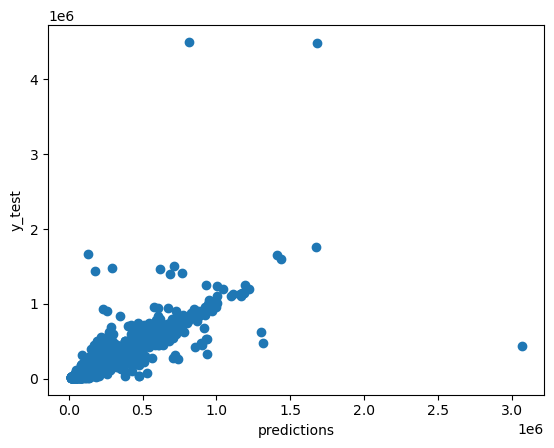

In [41]:
plt.scatter( predictions, y_test)
plt.xlabel("predictions")
plt.ylabel("y_test")
plt.show()

In [42]:
predictions

array([220903.77795148, 174358.53719661, 112038.25341954, ...,
       274622.9171138 , 243906.45081621, 104818.76190409])

In [43]:
y_test[1]

146000

In [44]:
# X_test_scaled[1]

In [45]:
rf_model.predict([X_test_scaled[1]])

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.2s finished


array([174358.53719661])

In [46]:
# #save the model 
#decided to save using pickle instead
# #https://scikit-learn.org/stable/model_persistence.html
# from joblib import dump, load
# dump(rf_model, 'salary_ml_model.joblib') 

In [48]:

dump(rf_model, open('salary_ml_model.pkl', 'wb'))
